In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
from datetime import datetime


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 999

In [2]:
from itertools import combinations
from scipy.stats import chi2_contingency, f_oneway
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix

In [3]:
def plot_respond_by_category(df_feature, key_columns, columns_group, columns_target, order,
               x_label, chart_name, rot = 0, figwidth = 15, figheigh = 5):
    
    from matplotlib.font_manager import FontProperties
        
    df = df_feature[df_feature[columns_group].notnull() & df_feature[columns_group].isin(order)]
    
    population = df[columns_group].value_counts(normalize = True).reindex(index = order) * 100
    
    response = df.groupby(columns_group)[columns_target].mean().reindex(index = order) * 100
    
    benchmark = round((df[columns_target].sum() / df.shape[0]) * 100, 3)
    
    table = df.groupby(columns_group).agg({key_columns:'count', columns_target:'sum'}).reindex(index = order).reset_index()
    table['% target'] = round(table[columns_target] * 100 / table[key_columns], 3)
    
    sum_population = pd.DataFrame({columns_group:['sum'], key_columns:[table[key_columns].sum()], columns_target:[table[columns_target].sum()], '% target':['-']})
    table = pd.concat([table, sum_population])
    
    table[key_columns] = table[key_columns].apply(lambda x: '{:,}'.format(x))
    table[columns_target] = table[columns_target].apply(lambda x: '{:,}'.format(x))
    table.rename(columns={columns_group:'x-axis'}, inplace = True)
    table_cols = table.columns
    table.rename(columns = {key_columns:'Population', '% target':f'% {columns_target}'}, inplace = True)
    
    fig, ax = plt.subplots(1,2)
    _ = population.plot(kind='bar', use_index=True, rot = rot, color = 'skyblue', ax = ax[0])
    ax_02 = ax[0].twinx()
    _ = ax_02.plot(response.values, linestyle='-', marker='o', linewidth=2.0, color = 'red')
    _ = ax[0].set_ylabel('% Population', color = 'skyblue', fontsize=15)
    _ = ax_02.set_ylabel(f'% {columns_target}', color = 'red', fontsize=15)
    _ = ax[0].set_xlabel('{} \n\n baseline: {}%'.format(x_label, benchmark), fontsize=10)
    _ = ax_02.axhline(y=benchmark, color='red', linestyle='--', lw=2)
    _ = ax[0].title.set_text(chart_name)
    
    #plot table
    t = ax[1].table(cellText=table.values,colLabels=table.columns,loc='center', cellLoc = 'center')
    t.auto_set_font_size(False)
    t.set_fontsize(10)
    t.scale(1, 3)
    _ = ax[1].axis('tight')
    _ = ax[1].axis('off')
    
    for (row, col), cell in t.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        elif (row == table.shape[0]):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    
    _ = fig.set_figwidth(figwidth)
    _ = fig.set_figheight(figheigh)
    _ = fig.tight_layout(pad=5.0)
    _ = plt.show()

---

# EDA

In [4]:
df = pd.read_csv('./train.csv')

In [5]:
df.head()
df.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Note: Three feature have missing values, namely, Age, Cabin, Embarked

### Survived (Target)

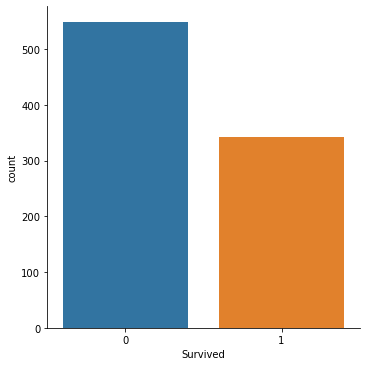

In [7]:
_ = sns.catplot(data = df, x = 'Survived', kind = 'count')

In [8]:
df.Survived.value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Note: The dataset is a bit imbalance but aceptable. No need to undersampling or oversampling for now.

### Pclass

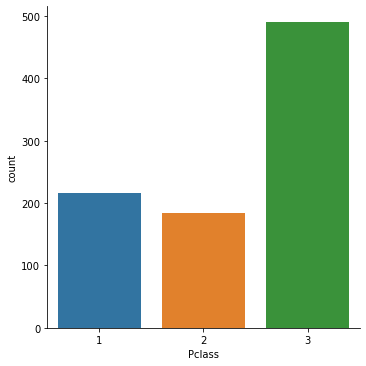

In [9]:
_ = sns.catplot(data = df, x = 'Pclass', kind = 'count')

There are 3 classes, namely, 1, 2 ,3.

### Name

In [10]:
df.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [11]:
def extract_title(Name):
    
    title = Name.split(',')[1].split('.')[0].strip()
    
    return title

In [12]:
df['Title'] = df.Name.apply(extract_title)

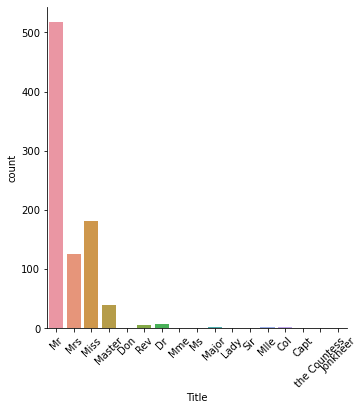

In [13]:
_ = sns.catplot(data = df, x = 'Title', kind = 'count')
_ = plt.xticks(rotation = 45)

Note: Grouping rare title into the group 'Others'

In [14]:
df['Title'] = np.where(df['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master']), df['Title'], 'Others')

In [15]:
df.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Others     27
Name: Title, dtype: int64

### Sex

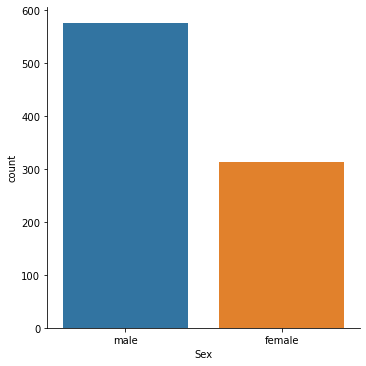

In [16]:
_ = sns.catplot(data = df, x = 'Sex', kind = 'count')

### Age

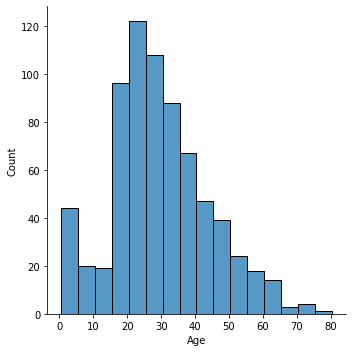

In [17]:
_ = sns.displot(data = df, x="Age", binwidth=5)

In [18]:
df.Age.isnull().sum()

177

The distibution is skewed, hence median is better summarizing the data. Therefore, missing values will be filled with the median of the training set.

### SibSp & Parch

In [19]:
df.SibSp.value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

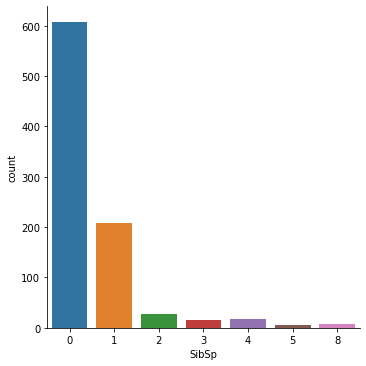

In [20]:
_ = sns.catplot(data = df, x = 'SibSp', kind = 'count')

In [21]:
df.Parch.value_counts().sort_index()

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

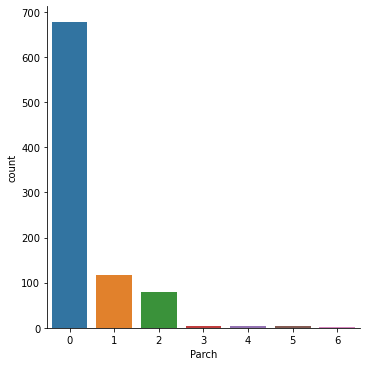

In [22]:
_ = sns.catplot(data = df, x = 'Parch', kind = 'count')

In [23]:
df['Family'] = df['SibSp'] + df['Parch']
df['Family'].value_counts().sort_index()

0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: Family, dtype: int64

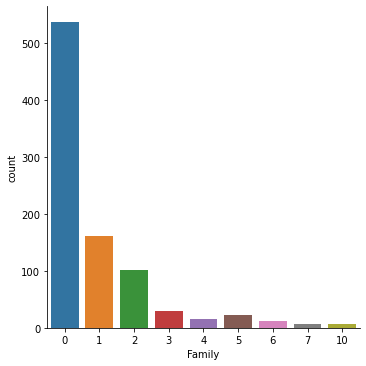

In [24]:
_ = sns.catplot(data = df, x = 'Family', kind = 'count')

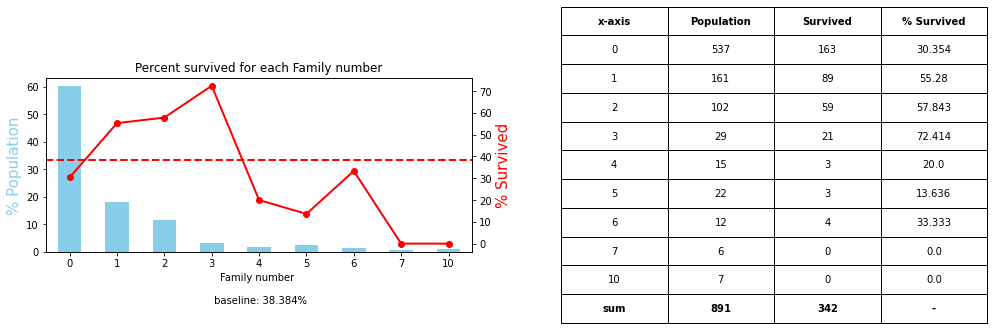

In [25]:
plot_respond_by_category(
    df_feature = df,
    key_columns = 'PassengerId',
    columns_group = 'Family',
    columns_target = 'Survived',
    order = df['Family'].value_counts().sort_index().index.tolist(),
    x_label = 'Family number',
    chart_name = 'Percent survived for each Family number',
    rot = 0,
    figwidth = 15,
    figheigh = 10)

grouping family number >= 3 into the same group

In [26]:
df['Family'] = np.where(df['Family'].isin([0,1,2]), df['Family'], '>=3')

### Ticket

In [27]:
df.Ticket.head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

Don't see any pattern, guessing that there is no information. So, nelect this feature.

### Fare

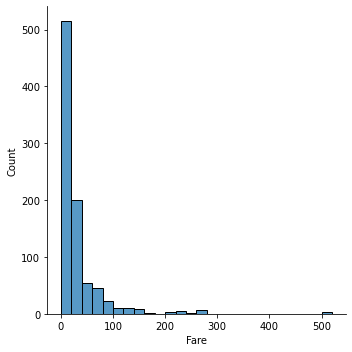

In [28]:
_ = sns.displot(data = df, x="Fare", binwidth=20)

### Cabin

In [29]:
df[df.Cabin.notnull()].Cabin.head(10)

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object

In [30]:
df['Cabin_group'] = df['Cabin'].str[0]

In [31]:
df['Cabin_group'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin_group, dtype: int64

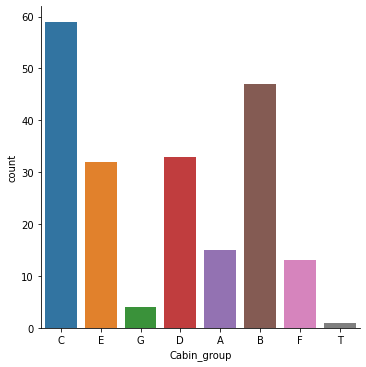

In [32]:
_ = sns.catplot(data = df, x = 'Cabin_group', kind = 'count')

In [33]:
df.Cabin.isnull().mean()

0.7710437710437711

Lots of data are missing. The new group, namely, 'Missing', will be introduce in this case.

In [34]:
df['Cabin_group'] = df['Cabin_group'].fillna('Missing')

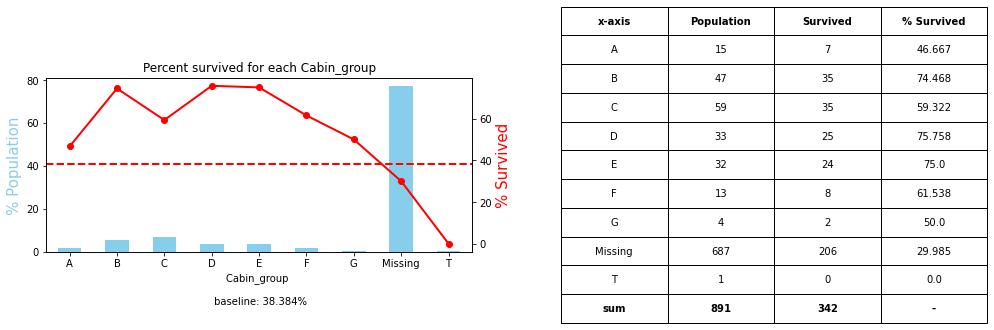

In [35]:
plot_respond_by_category(
    df_feature = df,
    key_columns = 'PassengerId',
    columns_group = 'Cabin_group',
    columns_target = 'Survived',
    order = df['Cabin_group'].value_counts().sort_index().index.tolist(),
    x_label = 'Cabin_group',
    chart_name = 'Percent survived for each Cabin_group',
    rot = 0,
    figwidth = 15,
    figheigh = 10)

Moreoverm grouping F,G,T into 'Others'

In [36]:
df['Cabin_group'] = np.where(df['Cabin_group'].isin(['F','G','T']), 'Others', df['Cabin_group'])

### Embarked

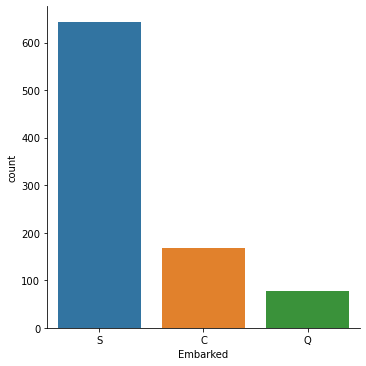

In [37]:
_ = sns.catplot(data = df, x = 'Embarked', kind = 'count')

In [38]:
df.Embarked.value_counts(normalize = True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

Note: The majority class for 'Embarked' is S which cover > 70% of the sample. The missing values could be imputed by this class. 

In [39]:
df['Embarked'] = df['Embarked'].fillna('S')

# Insight

In [40]:
categorical_feature = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family', 'Cabin_group']
numerical_feature = ['Age', 'Fare']

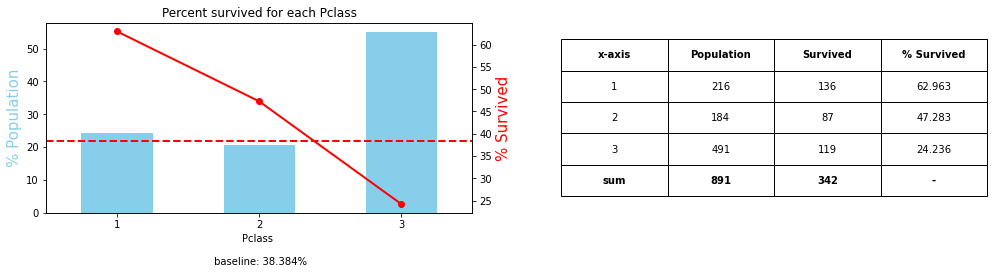

In [41]:
i = 'Pclass'
plot_respond_by_category(
        df_feature = df,
        key_columns = 'PassengerId',
        columns_group = i,
        columns_target = 'Survived',
        order = [1,2,3],
        x_label = i,
        chart_name = f'Percent survived for each {i}',
        rot = 0,
        figwidth = 15,
        figheigh = 5)

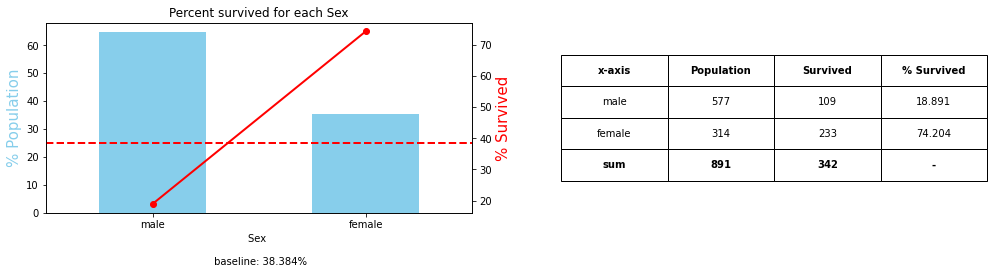

In [42]:
i = 'Sex'
plot_respond_by_category(
        df_feature = df,
        key_columns = 'PassengerId',
        columns_group = i,
        columns_target = 'Survived',
        order = df[i].unique(),
        x_label = i,
        chart_name = f'Percent survived for each {i}',
        rot = 0,
        figwidth = 15,
        figheigh = 5)

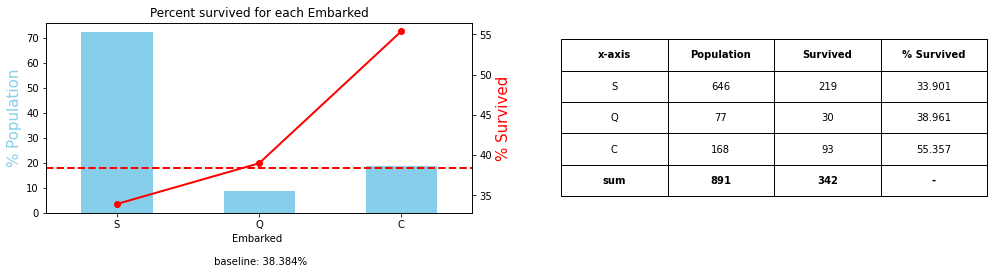

In [43]:
i = 'Embarked'
plot_respond_by_category(
        df_feature = df,
        key_columns = 'PassengerId',
        columns_group = i,
        columns_target = 'Survived',
        order = ['S', 'Q', 'C'],
        x_label = i,
        chart_name = f'Percent survived for each {i}',
        rot = 0,
        figwidth = 15,
        figheigh = 5)

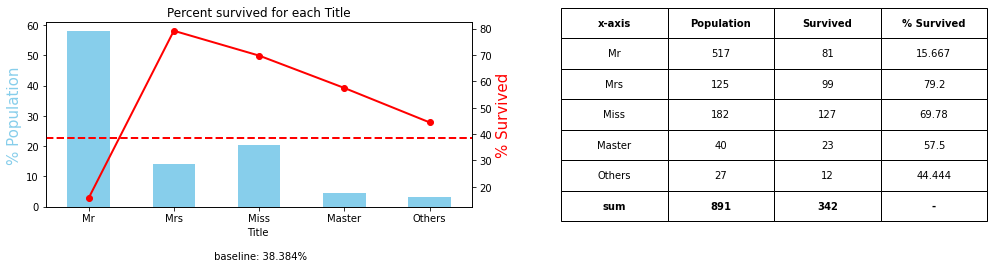

In [44]:
i = 'Title'
plot_respond_by_category(
        df_feature = df,
        key_columns = 'PassengerId',
        columns_group = i,
        columns_target = 'Survived',
        order = df[i].unique(),
        x_label = i,
        chart_name = f'Percent survived for each {i}',
        rot = 0,
        figwidth = 15,
        figheigh = 5)

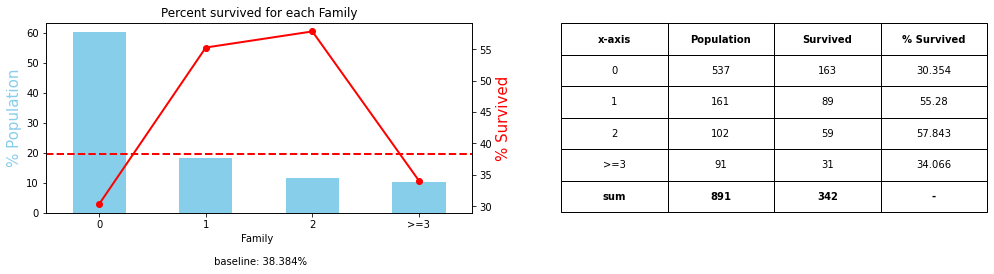

In [45]:
i = 'Family'
plot_respond_by_category(
        df_feature = df,
        key_columns = 'PassengerId',
        columns_group = i,
        columns_target = 'Survived',
        order = ['0','1','2','>=3'],
        x_label = i,
        chart_name = f'Percent survived for each {i}',
        rot = 0,
        figwidth = 15,
        figheigh = 5)

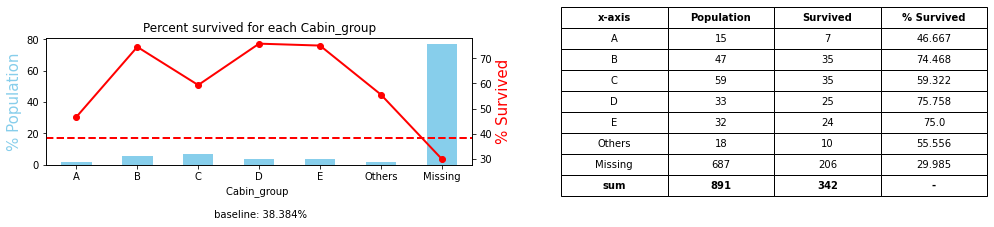

In [46]:
i = 'Cabin_group'
plot_respond_by_category(
        df_feature = df,
        key_columns = 'PassengerId',
        columns_group = i,
        columns_target = 'Survived',
        order = ['A','B','C','D','E','Others','Missing'],
        x_label = i,
        chart_name = f'Percent survived for each {i}',
        rot = 0,
        figwidth = 15,
        figheigh = 5)

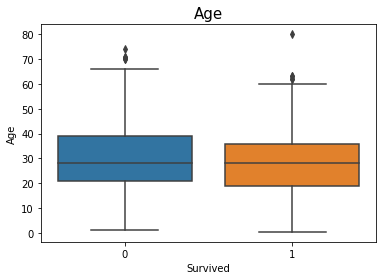

In [47]:
_ = sns.boxplot(data = df, y = 'Age', x = 'Survived', order=[0,1])
_ = plt.title('Age', fontsize = 15)
_ = plt.show()

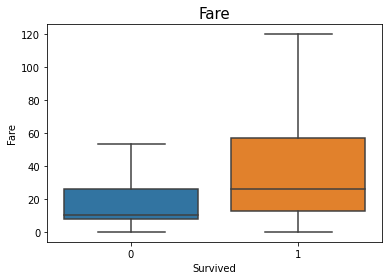

In [48]:
_ = sns.boxplot(data = df, y = 'Fare', x = 'Survived', order=[0,1], showfliers = False)
_ = plt.title('Fare', fontsize = 15)
_ = plt.show()

# Split data into train, validation and test set

In [49]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family,Cabin_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,Missing
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,Missing
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,Missing


In [50]:
df[categorical_feature] = df[categorical_feature].astype('category')

In [51]:
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'Family', 'Cabin_group']]
y = df['Survived']

In [52]:
X1, X_test, y1, y_test = train_test_split(X, y, random_state = 40, stratify = y, test_size = 0.1)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X1, y1, random_state = 40, stratify = y1, test_size = 0.1)

#will use this for gridsearch
split_index = [-1 if x in X_train.index else 0 for x in X1.index]

pds = PredefinedSplit(test_fold = split_index)

In [54]:
X_train.shape
X_val.shape
X_test.shape

y_train.shape
y_val.shape
y_test.shape

(720, 8)

(81, 8)

(90, 8)

(720,)

(81,)

(90,)

### impute missing age

In [55]:
age_mean = X_train.Age.median()

X_train['Age'] = X_train['Age'].fillna(age_mean)
X_val['Age'] = X_val['Age'].fillna(age_mean)
X_test['Age'] = X_test['Age'].fillna(age_mean)

<ipython-input-55-f01bd808b5c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Age'] = X_train['Age'].fillna(age_mean)
<ipython-input-55-f01bd808b5c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Age'] = X_val['Age'].fillna(age_mean)
<ipython-input-55-f01bd808b5c4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [56]:
X_train.isnull().sum().sum()
X_val.isnull().sum().sum()
X_test.isnull().sum().sum()

0

0

0

### check distribution of train, val, test set

Next, we check that the all train, validation and test set have the same distribution

In [57]:
categorical_feature = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family', 'Cabin_group']
numerical_feature = ['Age', 'Fare']

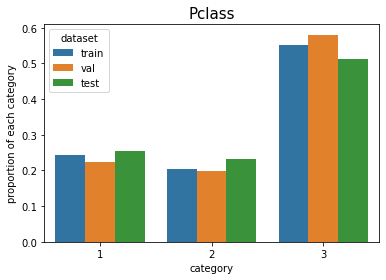

--------------------------------------------------------------------------------------------


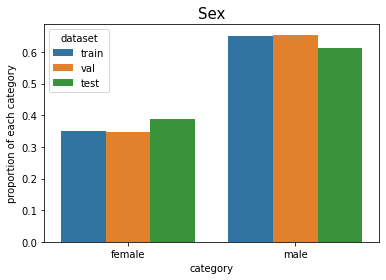

--------------------------------------------------------------------------------------------


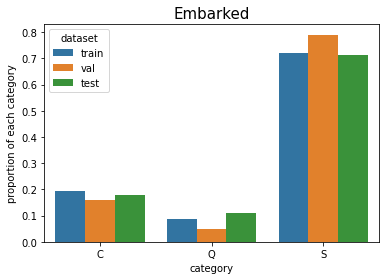

--------------------------------------------------------------------------------------------


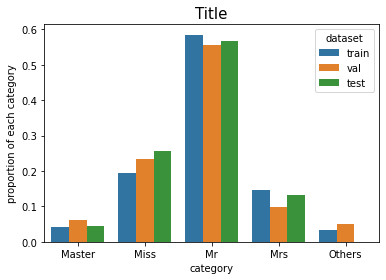

--------------------------------------------------------------------------------------------


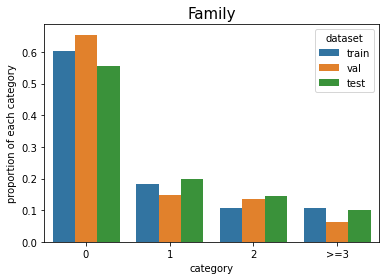

--------------------------------------------------------------------------------------------


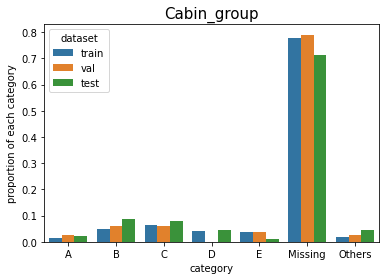

--------------------------------------------------------------------------------------------


In [58]:
for i in categorical_feature:
    dist_train = X_train[i].value_counts(normalize = True).reset_index()
    dist_train['dataset'] = 'train'

    dist_val = X_val[i].value_counts(normalize = True).reset_index()
    dist_val['dataset'] = 'val'

    dist_test = X_test[i].value_counts(normalize = True).reset_index()
    dist_test['dataset'] = 'test'
    
    tmp_df = pd.concat([dist_train,dist_val,dist_test])
    _ = sns.barplot(data = tmp_df, x = 'index', y = i, hue = 'dataset')
    _ = plt.xlabel('category')
    _ = plt.ylabel('proportion of each category')
    _ = plt.title(i, fontsize=15)
    _ = plt.show()
    
    print('--------------------------------------------------------------------------------------------')

In [59]:
dist_train = X_train.copy()
dist_train['dataset'] = 'train'

dist_val = X_val.copy()
dist_val['dataset'] = 'val'

dist_test = X_test.copy()
dist_test['dataset'] = 'test'

dist_all = pd.concat([dist_train, dist_val, dist_test])

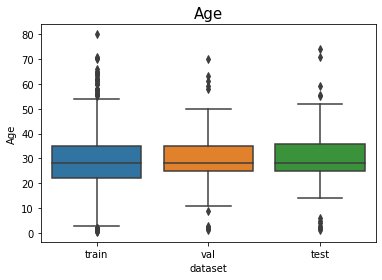

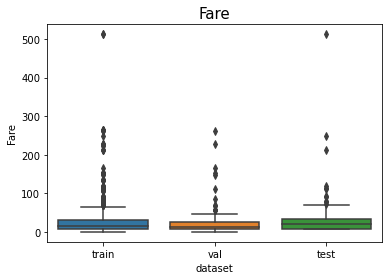

In [60]:
for i in numerical_feature:
    _ = sns.boxplot(data = dist_all, x = 'dataset', y = i)
    _ = plt.title(i, fontsize=15)
    _ = plt.show()

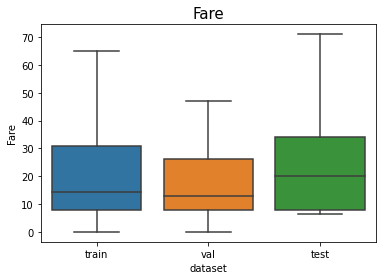

In [61]:
_ = sns.boxplot(data = dist_all, x = 'dataset', y = 'Fare', showfliers = False)
_ = plt.title('Fare', fontsize=15)
_ = plt.show()

All distribution are quite similar.

# Feature selection

### Remove constant feature

In [62]:
constant_feature = [x for x in X_train.columns if (df[x].nunique() == 1)]

In [63]:
constant_feature

[]

In [64]:
X_train.drop(columns = constant_feature, inplace = True)
X_val.drop(columns = constant_feature, inplace = True)
X_test.drop(columns = constant_feature, inplace = True)

/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Remove Quasi-constant feature

remove feature that > 99% of the values are the same

In [65]:
quasi_constant_feature = []
for x in X_train.columns:

    predominant = X_train[x].value_counts(normalize = True).sort_values(ascending=False).values[0]

    if predominant > 0.99:
        quasi_constant_feature.append(x)

In [66]:
quasi_constant_feature

[]

In [67]:
X_train.drop(columns = quasi_constant_feature, inplace = True)
X_val.drop(columns = quasi_constant_feature, inplace = True)
X_test.drop(columns = quasi_constant_feature, inplace = True)

### Remove duplicated feature

In [68]:
factors_paired = list(combinations(X_train.columns, 2))

duplicated_pair = []

for f in factors_paired:
    if X_train[f[0]].equals(X_train[f[1]]):
        duplicated_pair.append(f)

In [69]:
duplicated_pair

[]

### Remove corelated feature

<AxesSubplot:>

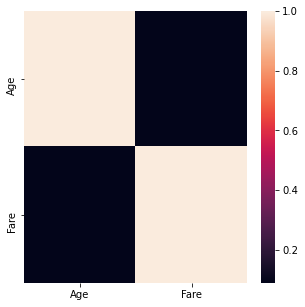

In [70]:
corrmat = X_train[numerical_feature].corr()
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corrmat)

In [71]:
corrmat

,Age,Fare
Age,1.000000,0.089789
Fare,0.089789,1.000000


No corelated feature in this case but in the case that some features are corelated we keep the one with higher corelation to the target.

### Select feature(numerical) that corelate to the target

ANOVA test (significance level = 0.1)

In [72]:
df_target = pd.DataFrame({'Survived':y_train})
df_stat = pd.concat([X_train, df_target], axis = 1)

In [73]:
selected_numerical_feature = []

grps = df_target.Survived.unique()

for i in numerical_feature:
    df_anova = df_stat[[i, 'Survived']]
    d_data = {grp:df_anova[df_anova.Survived == grp][i] for grp in grps}
    F, p = f_oneway(d_data[0], d_data[1])
    print(f'{i}: p value = {p}')
    if p < 0.1:
        selected_numerical_feature.append(i)

Age: p value = 0.0882044995539028
Fare: p value = 4.17760691641456e-10


In [74]:
selected_numerical_feature

['Age', 'Fare']

### Select feature(categorical) that corelate to the target

Chi2 test (significance level = 0.1)

In [75]:
selected_categorical_feature = []

for i in categorical_feature:
    chi2_test = chi2_contingency(pd.crosstab(df_stat[i], df_stat['Survived']))   
    print(f'{i}: p value = {chi2_test[1]}')
    if p < 0.1:
        selected_categorical_feature.append(i)

Pclass: p value = 5.551226519110159e-18
Sex: p value = 8.745446545973428e-48
Embarked: p value = 0.0007671627473891551
Title: p value = 1.0717927330303271e-48
Family: p value = 1.424498011722939e-08
Cabin_group: p value = 1.1704863398151357e-13


In [76]:
selected_categorical_feature

['Pclass', 'Sex', 'Embarked', 'Title', 'Family', 'Cabin_group']

### Final feature

In [77]:
final_feature = selected_numerical_feature + selected_categorical_feature

In [78]:
X_train = X_train[final_feature]
X_val = X_val[final_feature]
X_test = X_test[final_feature]

# Model

### check again

In [79]:
X_train.isnull().sum().sum()
X_val.isnull().sum().sum()
X_test.isnull().sum().sum()

y_train.isnull().sum().sum()
y_val.isnull().sum().sum()
y_test.isnull().sum().sum()

0

0

0

0

0

0

In [80]:
X_train.shape
X_val.shape
X_test.shape

y_train.shape
y_val.shape
y_test.shape

(720, 8)

(81, 8)

(90, 8)

(720,)

(81,)

(90,)

In [81]:
X_train.dtypes
X_val.dtypes
X_test.dtypes

Age             float64
Fare            float64
Pclass         category
Sex            category
Embarked       category
Title          category
Family         category
Cabin_group    category
dtype: object

Age             float64
Fare            float64
Pclass         category
Sex            category
Embarked       category
Title          category
Family         category
Cabin_group    category
dtype: object

Age             float64
Fare            float64
Pclass         category
Sex            category
Embarked       category
Title          category
Family         category
Cabin_group    category
dtype: object

Note: We did't do categorical encoding because we wil use LGBM feature to deal it.

### build a quick model

In [82]:
lgb_sklearn = LGBMClassifier(
    boosting_type = 'gbdt',
    objective = 'binary',
    metric = ['auc'],
    n_estimators = 1000,
    max_depth = 3,
    num_leaves = 8,
    learning_rate = 0.01,
    reg_alpha = 0.1,  
    reg_lambda = 0.1,
    feature_fraction = 0.9,
    bagging_fraction = 0.9,
)

In [83]:
lgb_sklearn.fit(X_train, y_train, verbose = 100,
          eval_metric = 'auc',
          eval_set = [(X_train, y_train),(X_val, y_val)]
        )

[100]	training's auc: 0.876236	valid_1's auc: 0.893871
[200]	training's auc: 0.889982	valid_1's auc: 0.896452
[300]	training's auc: 0.897808	valid_1's auc: 0.901935
[400]	training's auc: 0.904018	valid_1's auc: 0.908387
[500]	training's auc: 0.909355	valid_1's auc: 0.916774
[600]	training's auc: 0.91297	valid_1's auc: 0.915806
[700]	training's auc: 0.915153	valid_1's auc: 0.914516
[800]	training's auc: 0.919502	valid_1's auc: 0.916452
[900]	training's auc: 0.924052	valid_1's auc: 0.916452
[1000]	training's auc: 0.927059	valid_1's auc: 0.914516


LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.9, learning_rate=0.01,
               max_depth=3, metric=['auc'], n_estimators=1000, num_leaves=8,
               objective='binary', reg_alpha=0.1, reg_lambda=0.1)

Seem like the model can learn from our data.

### parameter tuning

In [84]:
param_grid = {
    'n_estimators':[500,700,1000],
    'max_depth':[2,3,4],
    'num_leaves':[8,16],
    'learning_rate':[0.01, 0.05],
    'reg_alpha':[0, 0.1],  
    'reg_lambda':[0, 0.1],
#     'feature_fraction':[0.9,1],
#     'bagging_fraction':[0.9,1],
}

In [85]:
estimator = LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', metric = ['auc'])

In [86]:
clf = GridSearchCV(estimator = estimator,
                   cv=pds,
                   param_grid=param_grid,
                   scoring = 'accuracy')

In [87]:
time_start = datetime.now()
clf.fit(X1,y1)
print('time collapes: ', datetime.now() - time_start)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0, -1])),
             estimator=LGBMClassifier(metric=['auc'], objective='binary'),
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [2, 3, 4],
                         'n_estimators': [500, 700, 1000],
                         'num_leaves': [8, 16], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [0, 0.1]},
             scoring='accuracy')

time collapes:  0:00:20.270875


In [88]:
clf.best_score_

0.8888888888888888

In [89]:
clf.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 700,
 'num_leaves': 16,
 'reg_alpha': 0,
 'reg_lambda': 0}

In [90]:
model1 = LGBMClassifier(
    boosting_type = 'gbdt',
    objective = 'binary',
    metric = ['auc'],
    n_estimators = 700,
    max_depth = 4,
    num_leaves = 16,
    learning_rate = 0.01,
    reg_alpha = 0,  
    reg_lambda = 0
)

In [91]:
model1.fit(X_train, y_train, verbose = 100,
          eval_metric = 'auc',
          eval_set = [(X_train, y_train),(X_val, y_val)]
        )

[100]	training's auc: 0.879178	valid_1's auc: 0.895806
[200]	training's auc: 0.907241	valid_1's auc: 0.905161
[300]	training's auc: 0.916871	valid_1's auc: 0.917419
[400]	training's auc: 0.922469	valid_1's auc: 0.919032
[500]	training's auc: 0.930531	valid_1's auc: 0.918387
[600]	training's auc: 0.935978	valid_1's auc: 0.915806
[700]	training's auc: 0.940348	valid_1's auc: 0.914516


LGBMClassifier(learning_rate=0.01, max_depth=4, metric=['auc'],
               n_estimators=700, num_leaves=16, objective='binary', reg_alpha=0,
               reg_lambda=0)

<AxesSubplot:>

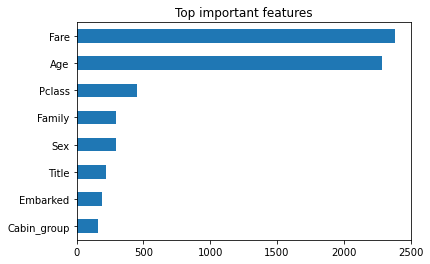

In [92]:
feat_importances = pd.Series(model1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
_ = plt.title("Top important features")
_ = plt.show()

### Evaluation

In [93]:
print('train accuracy: ', accuracy_score(y_train, model1.predict(X_train)))
print('validation accuracy: ', accuracy_score(y_val, model1.predict(X_val)))
print('test accuracy: ', accuracy_score(y_test, model1.predict(X_test)))

train accuracy:  0.8833333333333333
validation accuracy:  0.8518518518518519
test accuracy:  0.8444444444444444


The model is a bit overfit but in an acceptable level

In [94]:
print('train roc auc score: ', roc_auc_score(y_train, model1.predict_proba(X_train)[:,1]))
print('validation roc auc score: ', roc_auc_score(y_val, model1.predict_proba(X_val)[:,1]))
print('test roc auc score: ', roc_auc_score(y_test, model1.predict_proba(X_test)[:,1]))

train roc auc score:  0.9403479566523045
validation roc auc score:  0.914516129032258
test roc auc score:  0.9288311688311688


Train set

              precision    recall  f1-score   support

           0      0.872     0.950     0.909       444
           1      0.907     0.775     0.836       276

    accuracy                          0.883       720
   macro avg      0.889     0.863     0.873       720
weighted avg      0.885     0.883     0.881       720



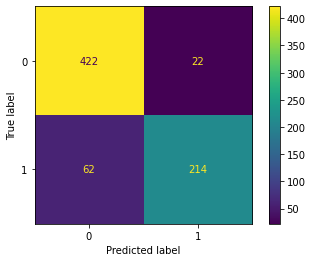

In [95]:
print('Train set\n')
print(classification_report(y_train, model1.predict(X_train), digits=3))
_ = plot_confusion_matrix(model1, X_train, y_train)

Validation set

              precision    recall  f1-score   support

           0      0.865     0.900     0.882        50
           1      0.828     0.774     0.800        31

    accuracy                          0.852        81
   macro avg      0.846     0.837     0.841        81
weighted avg      0.851     0.852     0.851        81



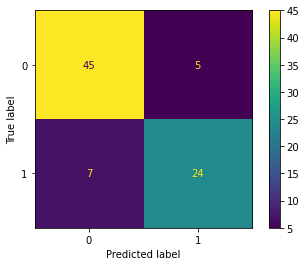

In [96]:
print('Validation set\n')
print(classification_report(y_val, model1.predict(X_val), digits=3))
_ = plot_confusion_matrix(model1, X_val, y_val)

Test set

              precision    recall  f1-score   support

           0      0.847     0.909     0.877        55
           1      0.839     0.743     0.788        35

    accuracy                          0.844        90
   macro avg      0.843     0.826     0.833        90
weighted avg      0.844     0.844     0.842        90



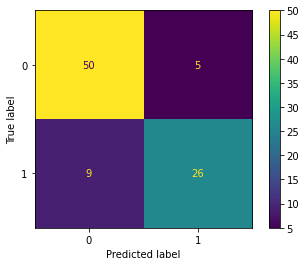

In [97]:
print('Test set\n')
print(classification_report(y_test, model1.predict(X_test), digits=3))
_ = plot_confusion_matrix(model1, X_test, y_test)